In [3]:
import numpy as np
from torchvision import datasets
from torchvision.transforms import transforms
from PIL import Image
import torch

# Download the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

# Function to resize images using bicubic interpolation
def resize_image(image, size=(16, 16)):
    return np.array(Image.fromarray(image).resize(size, Image.BICUBIC))

# Resize training images
X_train_resized = np.array([resize_image(img) for img in mnist_train.data.numpy()])
y_train = mnist_train.targets.numpy()

# Resize test images
X_test_resized = np.array([resize_image(img) for img in mnist_test.data.numpy()])
y_test = mnist_test.targets.numpy()

# Normalize the data
X_train_normalized = X_train_resized.astype('float32') / 255
X_test_normalized = X_test_resized.astype('float32') / 255

# Reshape the data
X_train_final = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_final = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_final)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test_final)
y_test_tensor = torch.from_numpy(y_test)

# Create TensorDataset
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

print("Resized MNIST dataset created successfully!")
print(f"Training set shape: {X_train_final.shape}")
print(f"Test set shape: {X_test_final.shape}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Resized MNIST dataset created successfully!
Training set shape: (60000, 256)
Test set shape: (10000, 256)


Epoch 1/10, Loss: 0.1840, Test Accuracy: 97.97%
Epoch 2/10, Loss: 0.0596, Test Accuracy: 98.23%
Epoch 3/10, Loss: 0.0468, Test Accuracy: 98.57%
Epoch 4/10, Loss: 0.0381, Test Accuracy: 98.62%
Epoch 5/10, Loss: 0.0325, Test Accuracy: 98.86%
Epoch 6/10, Loss: 0.0279, Test Accuracy: 98.69%
Epoch 7/10, Loss: 0.0250, Test Accuracy: 98.68%
Epoch 8/10, Loss: 0.0228, Test Accuracy: 98.66%
Epoch 9/10, Loss: 0.0208, Test Accuracy: 98.80%
Epoch 10/10, Loss: 0.0196, Test Accuracy: 98.86%


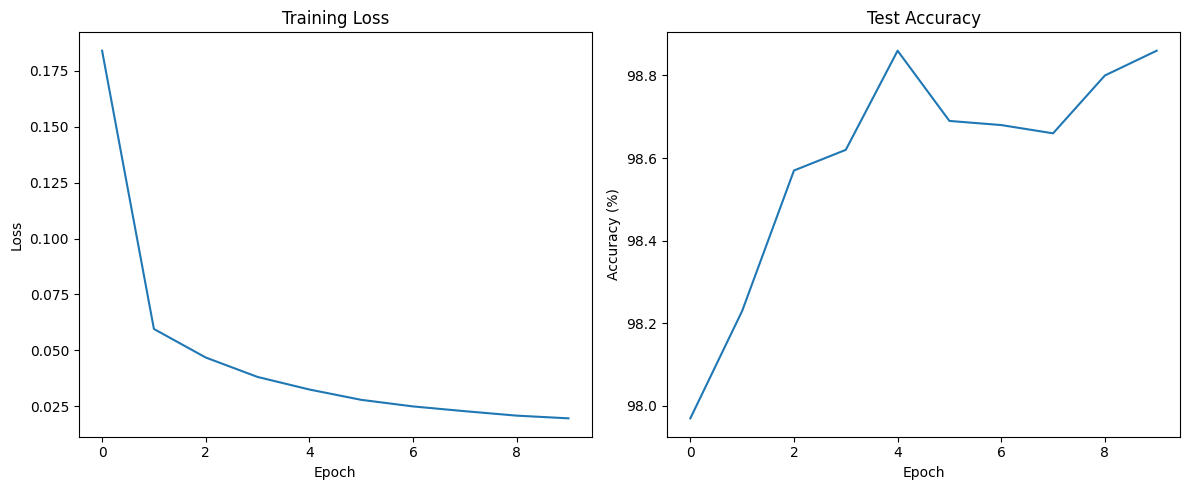

Training completed!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32 * 4 * 4, 32)
        self.output = nn.Linear(32, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, 16, 16)  # Reshape input to (batch_size, channels, height, width)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)  # Flatten
        x = torch.relu(self.fc(x))
        x = self.output(x)
        return nn.functional.log_softmax(x, dim=1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = MNISTModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {accuracy:.2f}%')

# Plot training loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

print("Training completed!")

In [5]:
class ImprovedMNISTModel(nn.Module):
    def __init__(self):
        super(ImprovedMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.view(-1, 1, 16, 16)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
        return torch.exp(output).numpy()

In [6]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = x.view(16, 16)  # Reshape to 2D image
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)

In [7]:
import torchvision.transforms as transforms

# Define the transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create the datasets
train_dataset_transformed = TransformDataset(train_dataset, transform=train_transform)
test_dataset_transformed = TransformDataset(test_dataset)  # No transforms for test data

Epoch 1/30, Loss: 0.7397, Test Accuracy: 9.74%
Epoch 2/30, Loss: 0.3678, Test Accuracy: 9.74%
Epoch 3/30, Loss: 0.2992, Test Accuracy: 9.74%
Epoch 4/30, Loss: 0.2636, Test Accuracy: 9.74%
Epoch 5/30, Loss: 0.2362, Test Accuracy: 9.74%
Epoch 6/30, Loss: 0.2235, Test Accuracy: 9.74%
Epoch 7/30, Loss: 0.2113, Test Accuracy: 9.74%
Epoch 8/30, Loss: 0.2016, Test Accuracy: 9.74%
Epoch 9/30, Loss: 0.1943, Test Accuracy: 9.74%
Epoch 10/30, Loss: 0.1832, Test Accuracy: 9.74%
Epoch 11/30, Loss: 0.1781, Test Accuracy: 9.74%
Epoch 12/30, Loss: 0.1726, Test Accuracy: 9.74%
Epoch 13/30, Loss: 0.1706, Test Accuracy: 9.74%
Epoch 14/30, Loss: 0.1662, Test Accuracy: 9.74%
Epoch 15/30, Loss: 0.1618, Test Accuracy: 9.74%
Epoch 16/30, Loss: 0.1557, Test Accuracy: 9.74%
Epoch 17/30, Loss: 0.1543, Test Accuracy: 9.74%
Epoch 18/30, Loss: 0.1507, Test Accuracy: 9.74%
Epoch 19/30, Loss: 0.1493, Test Accuracy: 9.74%
Epoch 20/30, Loss: 0.1462, Test Accuracy: 9.74%
Epoch 21/30, Loss: 0.1435, Test Accuracy: 9.74%
E

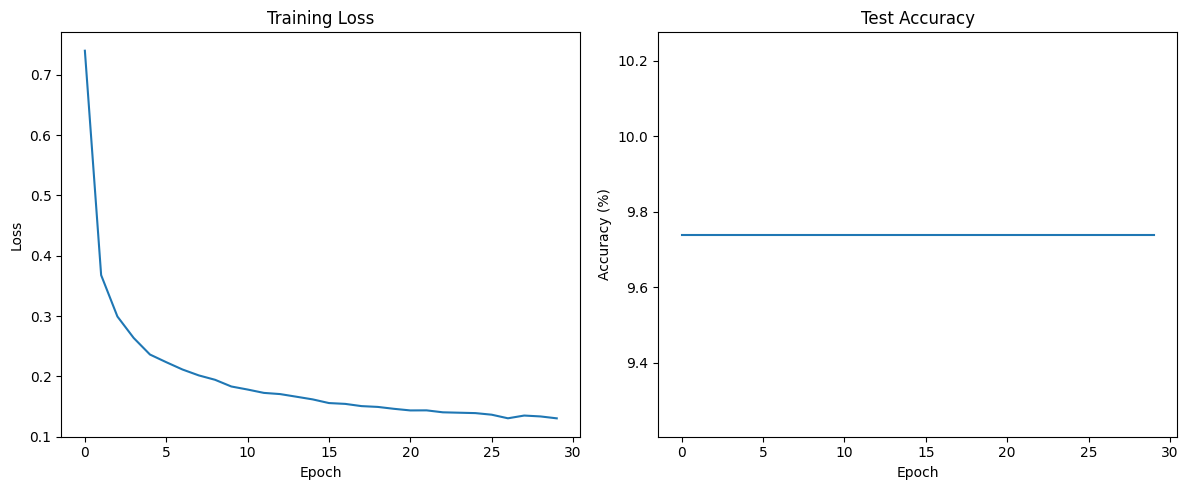

Training completed!


In [8]:
import torch.nn.functional as F


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = ImprovedMNISTModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size)

# Training loop
num_epochs = 30
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    train_losses.append(running_loss / len(train_loader))
    
    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {accuracy:.2f}%')

# Plot training loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

print("Training completed!")

even just on a conceptual level why did the accuracy tank so much just during training? also the fact that it keeps being about 9% accuracy tells me that if the test set is balanced its already just guessing the exact same digit every time

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Define your model
class MNISTModel(nn.Module):
    # ... (as defined earlier with dropout)

# Set up data transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create datasets and dataloaders
train_dataset = YourDataset(train_data, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model
model = MNISTModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    scheduler.step()  # Update the learning rate

    # Validation code here
    # ...

# Save the model
torch.save(model.state_dict(), 'mnist_model.pth')

In [4]:
import torch
import os

# Create a directory to save the model if it doesn't exist
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the entire model
model_path = os.path.join(save_dir, 'mnist_model.pth')
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

# Optionally, save additional information
info_dict = {
    'train_losses': train_losses,
    'test_accuracies': test_accuracies,
    'epochs': num_epochs,
    'batch_size': batch_size,
    'optimizer': optimizer.__class__.__name__,
    'learning_rate': optimizer.param_groups[0]['lr'],
}

info_path = os.path.join(save_dir, 'training_info.pth')
torch.save(info_dict, info_path)

print(f"Training information saved to {info_path}")

Model saved to saved_models\mnist_model.pth
Training information saved to saved_models\training_info.pth
